### **Project Showcase - Depression Detection using Twitter Data**

This script contains pre-processing for the twitter data and model creation using PyTorch.

We used TorchText, a PyTorch libray that made pre-pre-processing both simple and efficient, and applied custom techniques to work with our unique twitter data.

A lot of the preprocessing and model section was inspired by code from this article, as we are new to NLP using PyTorch - https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

In [ ]:
!pip install torchtext==0.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import os, sys
import re
import string
import itertools

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pandas version: 2.2.2
Pytorch version: 2.8.0+cu126
Torch Text version: 0.3.1
Spacy version: 3.8.7


## **1. Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/tweets_combined.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/tweets_combined.csv'

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia,0
1,1,I get to spend New Year's home again alone and lonely. ???•,1
2,2,"Depressed and lonely /: Stuck in a deep, never ending hole :(",1
3,3,"If this is your response to someone saying they're dealing with , you're a terrible person.",0
4,4,Apparently you get a free pass just by mentioning Where was I on the free badge day??!!,0


In [ ]:
df.target.value_counts()

,count
target,
0,2357
1,843


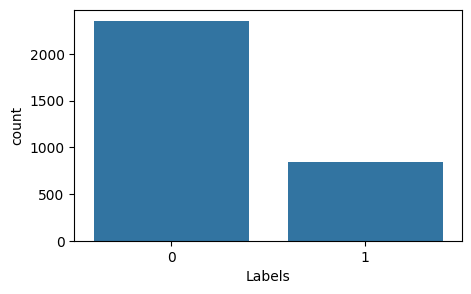

In [ ]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [ ]:
df.tweet.head(10), df.tweet.tail(10)

(0                                  Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
 1                                                                                        I get to spend New Year's home again alone and lonely. ???• 
 2                                                                                     Depressed and lonely /: Stuck in a deep, never ending hole :(  
 3                                                       If this is your response to someone saying they're dealing with , you're a terrible person.  
 4                                                          Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!
 5                                                                  When you will never again give birth to violent men..   pic.twitter.com/pkdPhhlUuZ
 6                                                    Learning to pretend to have a good time 

In [ ]:
# check non-depressive tweets
df[df["target"]==0].tweet.head()

,tweet
0,Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
3,"If this is your response to someone saying they're dealing with , you're a terrible person."
4,Apparently you get a free pass just by mentioning Where was I on the free badge day??!!
5,When you will never again give birth to violent men.. pic.twitter.com/pkdPhhlUuZ
7,Aw man im outta pizza rolls


In [ ]:
# check depressive tweets
df[df["target"]==1].tweet.head()

,tweet
1,I get to spend New Year's home again alone and lonely. ???•
2,"Depressed and lonely /: Stuck in a deep, never ending hole :("
6,Learning to pretend to have a good time had become a natural skill. I hope one day it is genuine
9,So far he stop texting me…after I said something…so hopefully he doesn't show up at my house…
11,*sigh* ???? I haven't cried so much…I'm in so much pain…


## **2. Define How to Preprocess Data**

In [ ]:
# torchtext have trouble handling \n. Replace \n character with space
df['tweet'] = df.tweet.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 3200/3200 [00:00<00:00, 347273.48it/s]


In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

In [ ]:
nlp = spacy.load('en_core_web_sm',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

**Define fields**

In [ ]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =False)

In [ ]:
data_fields = [
    (None, None),
    ("tweet", TEXT),
    ("target", TARGET)
]

## **3. Create Train, Valid and Test datasets**

In [ ]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [ ]:
# create train and validation set
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [ ]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [ ]:
train.shape, val.shape, test.shape

((2048, 3), (512, 3), (640, 3))

[Text(0.5, 0, 'Labels'), Text(0, 0.5, 'counts'), Text(0.5, 1.0, 'test')]

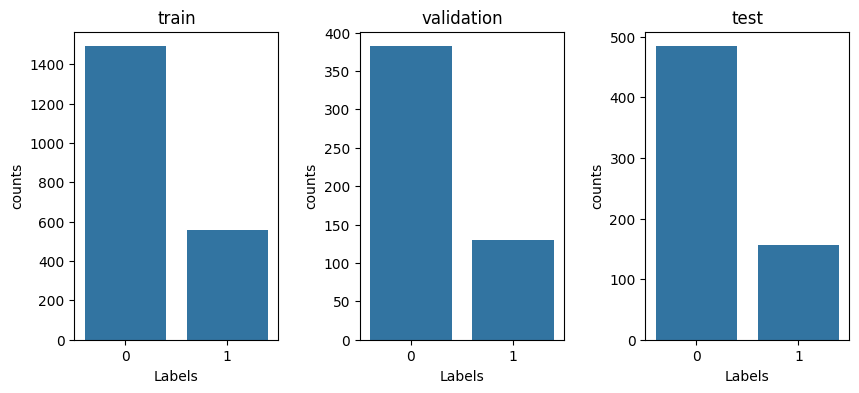

In [ ]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [ ]:
%%time
train_data, val_data, test_data = TabularDataset.splits(path='./', format='csv', train='train.csv', validation='val.csv', test='test.csv', fields=data_fields, skip_header=True)

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


CPU times: user 14.5 s, sys: 13.3 ms, total: 14.6 s
Wall time: 22.8 s


In [ ]:
len(train_data), len(val_data), len(test_data)

(2048, 512, 640)

## **4. Load pretrained embeddings and build vocab**

In [ ]:
!ls '/content/gdrive/My Drive/embedding'

glove.twitter.27B.100d.txt


In [ ]:
%%time
# Assuming 1,200,000 words and 100 dimensions for glove.twitter.27B.100d
# Update the path to reflect the location within your Google Drive
vec = torchtext.vocab.Vectors('/content/drive/MyDrive/embedding/glove.twitter.27B.100d.txt', max_vectors=1200000)

100%|█████████▉| 1193513/1193514 [01:12<00:00, 16457.86it/s]


CPU times: user 1min 11s, sys: 2.09 s, total: 1min 13s
Wall time: 1min 35s


In [ ]:
!ls '/content/gdrive/My Drive/'

'Alok Maurya Santosh CV.pdf'
'Alok Santosh Maurya .CV (2) 5 (1)_compressed.pdf'
'blck book1.pdf'
 Classroom
 class.txt
'Colab Notebooks'
 data
 depression-detection-master
'depression-detection-master (1).zip'
 embedding
 id.odt
'IMG20210829185408 (1).jpg'
'IMG20210829185408 (2).jpg'
 IMG20210829185408.jpg
 IMG20240502162539.jpg
'IMG20250307133458 (1).jpg'
 IMG20250307133458.jpg
'IMG20250307133503 (1).jpg'
 IMG20250307133503.jpg
'IMG20250307133510 (1).jpg'
 IMG20250307133510.jpg
'IMG20250307133517 (1).jpg'
 IMG20250307133517.jpg
'IMG20250307133524 (1).jpg'
 IMG20250307133524.jpg
'IMG20250307133530 (1).jpg'
 IMG20250307133530.jpg
'Mar 7, 2025 at 1:46 PM (1).jpg'
'Mar 7, 2025 at 1:46 PM (2).jpg'
'Mar 7, 2025 at 1:46 PM.jpg'
'Mar 7, 2025 at 1:47 PM (1).jpg'
'Mar 7, 2025 at 1:47 PM.jpg'
'Mar 7, 2025 at 1:48 PM.jpg'
'Mar 7, 2025 at 1:50 PM (1).jpg'
'Mar 7, 2025 at 1:50 PM (2).jpg'
'Mar 7, 2025 at 1:50 PM (3).jpg'
'Mar 7, 2025 at 1:50 PM.jpg'
'Mar 7, 2025 at 1:53 PM.jpg'
'Mar 7, 2025 at 2:23

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/gdrive/My Drive/embedding'

ls: cannot access '/content/gdrive/My Drive/embedding': Transport endpoint is not connected


In [ ]:
len(train_data)

2048

In [ ]:
%%time
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

CPU times: user 89.2 ms, sys: 6.93 ms, total: 96.1 ms
Wall time: 101 ms


In [ ]:
TEXT.vocab.vectors.shape

torch.Size([5470, 100])

In [ ]:
train_data

## **5. Load data in batches**

We will use the BucketIterator to access the Dataloader. It sorts data according to length of text, and groups similar length text in a batch, thus reducing the amount of padding required. It pads the batch according to the max length in that particular batch

In [ ]:

train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data),
                                            batch_sizes=(3,3,3),
                                            sort_key=lambda x: len(x.tweet),
                                            device=None,
                                            sort_within_batch=True,
                                            repeat=False)

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(683, 171, 214)

In [ ]:
batch = next(iter(train_loader))
type(batch)

torchtext.data.batch.Batch

In [ ]:
batch.target

tensor([0, 0, 0])

In [ ]:
batch.tweet

(tensor([[  21,  131,   43],
         [4526,   52,  221],
         [1894, 1095,  105],
         [  25,   26,   18],
         [  15, 1094,   94],
         [  38,   43,    5],
         [   6,    6,  207],
         [ 629,  750,   84],
         [ 209,    5,   77],
         [ 570, 1149,  277],
         [   8,    2,  772],
         [  78,   42,    2],
         [  79,  202,  658],
         [4420,   40,  880],
         [   9,   19, 1183],
         [ 563,   10,  596],
         [ 696,   13,  596],
         [ 693,   13,  997]]),
 tensor([18, 18, 18]))

In [ ]:
TEXT.vocab.itos[1]

'<pad>'

In [ ]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.tweet[0][:,idx].cpu().data.numpy()])

In [ ]:
idxtosent(batch,0)

'that rap reminds me of when the kids were small and they would prepare a performance cute crap'

In [ ]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x7acf0dbb3740>,
 'fields': dict_keys([None, 'tweet', 'target']),
 'input_fields': ['tweet', 'target'],
 'target_fields': [],
 'tweet': (tensor([[  21,  131,   43],
          [4526,   52,  221],
          [1894, 1095,  105],
          [  25,   26,   18],
          [  15, 1094,   94],
          [  38,   43,    5],
          [   6,    6,  207],
          [ 629,  750,   84],
          [ 209,    5,   77],
          [ 570, 1149,  277],
          [   8,    2,  772],
          [  78,   42,    2],
          [  79,  202,  658],
          [4420,   40,  880],
          [   9,   19, 1183],
          [ 563,   10,  596],
          [ 696,   13,  596],
          [ 693,   13,  997]]),
  tensor([18, 18, 18])),
 'target': tensor([0, 0, 0])}

In [ ]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [ ]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
next(iter(train_batch_it))

((tensor([[   4, 3711,  124],
          [  46, 2489, 4269],
          [ 365, 5285, 3982],
          [   5,   19,   11],
          [ 284, 2614,   60],
          [ 117, 1814, 1272],
          [   5,   28,  117],
          [ 177, 1140,   25],
          [  18, 2488,   18]]),
  tensor([9, 9, 9])),
 tensor([1, 0, 0]))

The notebook uses **Recurrent Neural Network (RNN) based algorithms**, specifically:

* **GRU (Gated Recurrent Unit)**
* A custom model class called **`ConcatPoolingGRUAdaptive`**, which is a neural network built using PyTorch.

Would you like me to go through the model definition in detail and explain how this GRU-based depression detector works?


## **6. Models and Training**



In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 2

In [ ]:
# Define a PyTorch module named ConcatPoolingGRUAdaptive
class ConcatPoolingGRUAdaptive(nn.Module):

    # Constructor with the following arguments
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True):

        # Call the constructor of the nn.Module class
        super().__init__()

        # Initialize instance variables
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional

        # Create an embedding layer with a size of vocab_size x embedding_dim
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)

        # Load pre-trained word embeddings into the embedding layer
        self.emb.weight.data.copy_(pretrained_vec)

        # Freeze the embedding layer during training
        self.emb.weight.requires_grad = False

        # Create a GRU layer with input size of embedding_dim and hidden size of n_hidden
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)

        # Create a fully-connected linear layer to map GRU output to class scores
        if bidirectional:
            self.fc = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.fc = nn.Linear(self.n_hidden*2, self.n_out)

        # Create a dropout layer with dropout probability of dropout
        self.dropout = nn.Dropout(dropout)

    # Define the forward method for the module
    def forward(self, seq, lengths):
        bs = seq.size(1)

        # Initialize the hidden state of the GRU
        self.h = self.init_hidden(bs)

        # Transpose input sequence to batch-first format
        seq = seq.transpose(0,1)

        # Pass input sequence through the embedding layer
        embs = self.emb(seq)

        # Transpose embeddings back to sequence-first format
        embs = embs.transpose(0,1)

        # Pack the sequence of embeddings using lengths to avoid computing on padded elements
        embs = pack_padded_sequence(embs, lengths)

        # Pass packed embeddings through the GRU
        gru_out, self.h = self.gru(embs, self.h)

        # Unpack the sequence and remove padding
        gru_out, lengths = pad_packed_sequence(gru_out)

        # Apply adaptive max and average pooling to the GRU output along the time dimension
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)

        # Concatenate the average and max pooled outputs and apply dropout
        cat = self.dropout(torch.cat([avg_pool,max_pool],dim=1))

        # Map the concatenated output to class scores
        outp = self.fc(cat)

        # Apply log softmax to class scores and return
        return F.log_softmax(outp)

    # Helper method to initialize the hidden state of the GRU
    def init_hidden(self, batch_size):
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [ ]:
def train(model, iterator, optimizer, criterion, num_batch):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        #t = tqdm_notebook(iterator, leave=False, total=num_batch)

        for (X,lengths),y in iterator:

          #t.set_description(f'Epoch {epoch}')
          lengths = lengths.cpu().numpy()

          opt.zero_grad()
          pred = model(X, lengths)
          loss = criterion(pred, y)
          loss.backward()
          opt.step()

          #t.set_postfix(loss=loss.item())
          pred_idx = torch.max(pred, dim=1)[1]

          y_true_train += list(y.cpu().data.numpy())
          y_pred_train += list(pred_idx.cpu().data.numpy())
          total_loss_train += loss.item()

        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/num_batch
        return train_loss, train_acc

In [ ]:
def evaluate(model, iterator, criterion, num_batch):
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in iterator: #tqdm_notebook(iterator, leave=False):

              pred = model(X, lengths.cpu().numpy())
              loss = criterion(pred, y)
              pred_idx = torch.max(pred, 1)[1]
              y_true_val += list(y.cpu().data.numpy())
              y_pred_val += list(pred_idx.cpu().data.numpy())
              total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/num_batch
            return valloss, valacc


In [ ]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data),
                                            batch_sizes=(32,32,32),
                                            sort_key=lambda x: len(x.tweet),
                                            device=device,
                                            sort_within_batch=True,
                                            repeat=False)

In [ ]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
val_batch_it = BatchGenerator(val_loader, 'tweet', 'target')
test_batch_it = BatchGenerator(test_loader, 'tweet', 'target')

In [ ]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['tweet'].vocab.vectors, 0.5).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)


In [ ]:
loss_fn=F.nll_loss
epochs=10

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

epochs=10

for epoch in range(epochs):

    start_time = time.time()

    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), 'tut4-model.pt')


    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f}')


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 0: train_loss: 0.5802 train_acc: 0.7227 | val_loss: 0.5169 val_acc: 0.7656


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 1: train_loss: 0.4868 train_acc: 0.7646 | val_loss: 0.4825 val_acc: 0.7734


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 2: train_loss: 0.4315 train_acc: 0.7944 | val_loss: 0.4769 val_acc: 0.7461


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 3: train_loss: 0.4067 train_acc: 0.8115 | val_loss: 0.4495 val_acc: 0.7812


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 4: train_loss: 0.3764 train_acc: 0.8320 | val_loss: 0.4543 val_acc: 0.8027


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 5: train_loss: 0.3626 train_acc: 0.8306 | val_loss: 0.4509 val_acc: 0.8047


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 6: train_loss: 0.3670 train_acc: 0.8262 | val_loss: 0.5334 val_acc: 0.7676


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 7: train_loss: 0.3343 train_acc: 0.8491 | val_loss: 0.4667 val_acc: 0.7695


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)
/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 8: train_loss: 0.3048 train_acc: 0.8623 | val_loss: 0.4693 val_acc: 0.8008


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 9: train_loss: 0.2926 train_acc: 0.8672 | val_loss: 0.4810 val_acc: 0.7969


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


In [ ]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.443 | Test Acc: 81.88%


/tmp/ipython-input-996433491.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Logistic Regression (simple & strong baseline)


In [ ]:
import pandas as pd
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Load your data (replace with actual file paths or sources)
train = pd.read_csv("train.csv")  # Ensure 'tweet' and 'target' columns exist
test = pd.read_csv("test.csv")

# 2. Contractions dictionary
contraction_dict = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am", "I've": "I have",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
    "this's": "this is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
    "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(map(re.escape, contraction_dict.keys())))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# 3. Tweet cleaning function
def tweet_clean(text):
    text = str(text).lower()
    text = re.sub(r'https?:\/\/\S+', ' ', text)  # Remove URLs
    text = re.sub(r'<[^>]+>', ' ', text)         # Remove HTML tags / emojis
    text = re.sub(r'@\w+', ' ', text)            # Remove mentions
    text = re.sub(r'#', '', text)                # Remove hashtag symbol
    text = re.sub(r'\d+', ' ', text)             # Remove numbers
    text = replace_contractions(text)            # Expand contractions
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)                # Normalize spaces
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))  # Remove excessive character repetition
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text)  # Keep only certain punctuation
    return text.strip()

# 4. Clean train and test tweets
train['tweet'] = train['tweet'].apply(tweet_clean)
test['tweet'] = test['tweet'].apply(tweet_clean)

# 5. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train['tweet'])
X_test_tfidf = vectorizer.transform(test['tweet'])

# 6. Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, train['target'])

# 7. Predict and evaluate
y_pred = lr.predict(X_test_tfidf)
print("Logistic Regression Results:\n")
print(classification_report(test['target'], y_pred))


Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       484
           1       0.73      0.35      0.47       156

    accuracy                           0.81       640
   macro avg       0.77      0.65      0.68       640
weighted avg       0.80      0.81      0.78       640



Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Assuming 'train' and 'test' dataframes are already defined and cleaned
# If not, make sure to load and clean them before this cell

# Define X and y
X_train = train['tweet']
y_train = train['target']
X_test = test['tweet']
y_test = test['target']

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred = nb.predict(X_test_tfidf)
print("Naive Bayes Results:\n", classification_report(y_test, y_pred))

Naive Bayes Results:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       484
           1       1.00      0.01      0.01       156

    accuracy                           0.76       640
   macro avg       0.88      0.50      0.44       640
weighted avg       0.82      0.76      0.65       640



Support Vector Machine (SVM)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Assuming 'train' and 'test' dataframes are already defined and cleaned
# If not, make sure to load and clean them before this cell

# Define X and y
X_train = train['tweet']
y_train = train['target']
X_test = test['tweet']
y_test = test['target']

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred = svm.predict(X_test_tfidf)
print("SVM Results:\n", classification_report(y_test, y_pred))

SVM Results:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       484
           1       0.53      0.51      0.52       156

    accuracy                           0.77       640
   macro avg       0.69      0.68      0.69       640
weighted avg       0.77      0.77      0.77       640




🔹 Logistic Regression 🔹
Training Accuracy: 0.8348
Testing Accuracy:  0.8047

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88       484
           1       0.72      0.32      0.44       156

    accuracy                           0.80       640
   macro avg       0.77      0.64      0.66       640
weighted avg       0.79      0.80      0.77       640



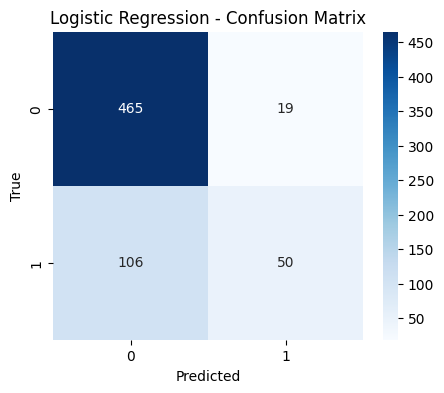


🔹 Naive Bayes 🔹
Training Accuracy: 0.7750
Testing Accuracy:  0.7594

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       484
           1       1.00      0.01      0.03       156

    accuracy                           0.76       640
   macro avg       0.88      0.51      0.44       640
weighted avg       0.82      0.76      0.66       640



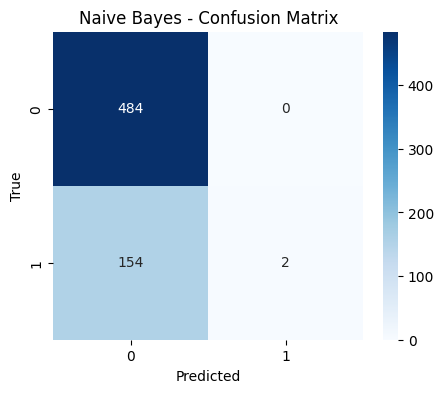


🔹 SVM 🔹
Training Accuracy: 0.9793
Testing Accuracy:  0.7828

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       484
           1       0.56      0.54      0.55       156

    accuracy                           0.78       640
   macro avg       0.70      0.70      0.70       640
weighted avg       0.78      0.78      0.78       640



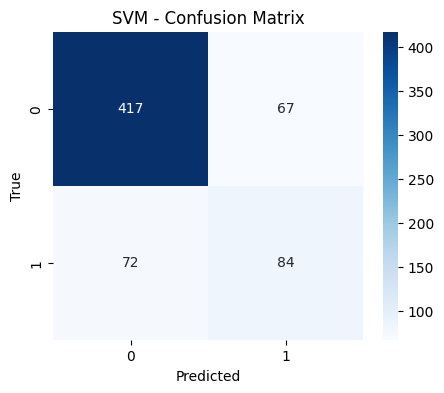


🔹 Random Forest 🔹
Training Accuracy: 0.9996
Testing Accuracy:  0.7734

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.87       484
           1       0.63      0.17      0.26       156

    accuracy                           0.77       640
   macro avg       0.71      0.57      0.57       640
weighted avg       0.75      0.77      0.72       640



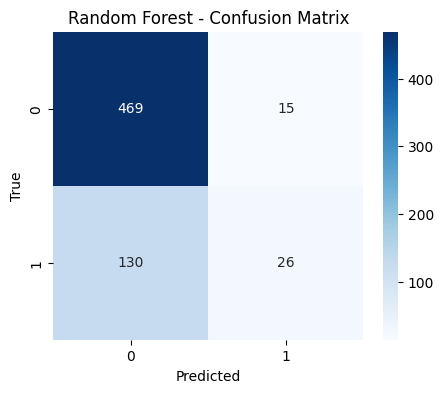

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example: assuming you have dataframe df with columns ["text", "label"]
# Replace df["text"], df["label"] with your dataset
X = df["tweet"]
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Dictionary of models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# Function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n🔹 {name} 🔹")
    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy:  {test_acc:.4f}")

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Run all models
for name, model in models.items():
    evaluate_model(name, model, X_train_tfidf, y_train, X_test_tfidf, y_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Take a small subset of the tweet data
subset_tweets = train['tweet'].head(10)

# Apply TfidfVectorizer to the subset
vectorizer_subset = TfidfVectorizer(max_features=5000)
X_train_tfidf_subset = vectorizer_subset.fit_transform(subset_tweets)

print("TF-IDF vectorization on subset successful.")
print(X_train_tfidf_subset.shape)

TF-IDF vectorization on subset successful.
(10, 129)


In [ ]:
print(train['tweet'].head())

0                                   i really wish i would have more time to draw blog about . i am sure they would be helpful to many..
1    why do you cut your ankle? it is easier to hide and i cannot handle people finding out they will pretend to care and hurt me again
2                                                 everything is coming back to me all of a sudden. this .. is not a good feeling at all
3                      so after a month hiatus, i watch a movie in a multiplex and it is ugly! maybe i was better off not watching any.
4                                                no matter how much lights up the forest, they end up getting lost nzescoforest nssbola
Name: tweet, dtype: object
